In [9]:
import numpy as np
import segyio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
from scipy import signal

In [10]:
from ukpgks import segy
data = segy.read_segy('gather_38.segy',coors=False)

In [28]:
# Statistical Wavelet Extraction
def wavelet_stat_2D(data,dt,phase=2*np.pi):
    """
    Statistical Wavelet Extraction. The frequency spectra of the autocorrelation
    of all input traces are stacked to produce the wavelet.

    1. Calculate the autocorrelation of each trace in the analysis window.
    2. Calculate the frequency spectrum of each autocorrelation.
       Take the square root of the modulus of each frequency spectrum,
       the zero Hertz component is muted to zero. This step approximates the wavelet spectrum
    3. Stack the spectra
    4. Add the wavelet phase
    5. Take the inverse Fast Fourier Transform (FFT) to extract the wavelet

    Input
    data                   [traces:times]
    dt                     sampling rate of data in sec
    phase=2*pi (positive)  [np.pi,...]

    Output:
    Dataframe with columns
    wavelet, time, frequencies
    """
    traces = data.shape[0]
    autocorrelations = np.zeros_like(data)
    spectrum_autocor = np.zeros_like(data,dtype='complex64')
    for trace in range(traces):
        autocorrelations[trace,:] = np.correlate(data[trace,:],data[trace,:],mode='same')
        auto = autocorrelations[trace,:]

        spec = np.fft.fft(auto)
        spec = np.sqrt(np.abs(spec))
        #spec = spec * np.exp(-1j*phase)

        spectrum_autocor[trace,:] = spec

    spec_stacked = np.sum(spectrum_autocor,axis=0)
    spec_stacked = spec_stacked * np.exp(-1j*phase)
    w = np.fft.ifft(spec_stacked)
    w = np.fft.ifftshift(w)

    out  = np.real(w)
    Nt   = data.shape[1]
    fnq  = 1 / (2*dt)
    freq = np.linspace(0,fnq,int(Nt))
    time = np.linspace(0,Nt*dt,int(Nt))

    data = np.array([out,time,freq])
    df   = pd.DataFrame(data=data.T,columns=['wavelet','time','frequency'])

    return df     #out,time,freq


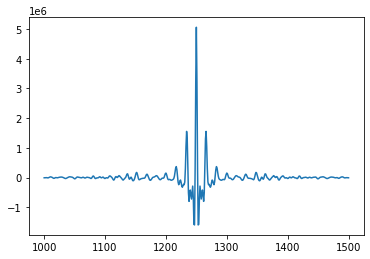

In [29]:
df = wavelet_stat_2D(data,0.01)
plt.plot(df.loc[1000:1500,'wavelet'])